<img src="http://landlab.github.io/assets/Landlab-logo.png"
style="float:left;width:150px;padding:0px">  

<br /> 

# Reuse a published regional Landlab shallow landslide model to explore changes in forest cover at a subcatchment within the study area<br /> 
### You will explore how to reuse model code and data in a subregion within a larger region where the model was developed 
* Load data from a regional Landlab landslide model (Strauch et al., 2018) developed for the North Cascades National Park, WA USA, published on HydroShare. <br />
* Define a geographic subset (Thunder Creek watershed) within the study region.
* Explore landslide probability sensitivity to fire by adjusting the cohesion parameter for Thunder Creek.
* Save results to a new HydroShare resource.  <br />

The shallow landslide model you will is based on a spatially distributed Monte Carlo solution of the infinite slope stability model. Detailes of the model and the study site are described in Strauch et al. (2018).

Strauch R., Istanbulluoglu E., Nudurupati S.S., Bandaragoda C., Gasparini N.M., and G.E. Tucker (2018). A hydro-climatological approach to predicting regional landslide probability using Landlab. Earth Surf. Dynam., 6, 1–26. 
https://www.earth-surf-dynam.net/6/1/2018/

 <br /> <img src="https://www.washington.edu/brand/files/2014/09/W-Logo_Purple_Hex.png" style="float:right;width:120px;padding:10px">   

## To run this notebook:

Click in each shaded cell below and "shift + enter" to run each code block. Alternatively, you can run groups of cells by clicking "Cell" on the menu above and selecting your run options from the pull-down menu. This is also where you can clear outputs from previous runs.

If an error occurs, click on *Kernal* and *Restart and Clear Outputs* in the menu above.

## 1. Introduction

** 1.1 Infinite Slope Factor of Safety Equation **

This equation predicts the ratio of stabilizing to destabilizing forces on a hillslope plane. The properties are assumed to represent an infinte plane, neglecting the boundary conditions around the landslide location. When FS<1, the slope is instable.

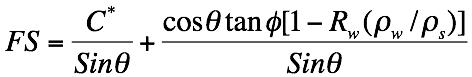

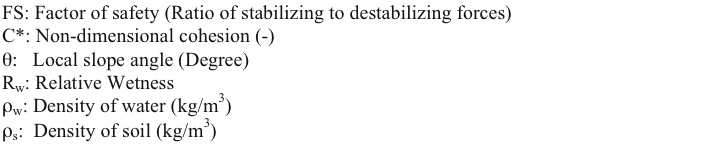

C* can be calculated by the ratio of the sum of root cohesion, Cr, and soil cohesion, Cs, to the product of soil depth, density, and gravity.

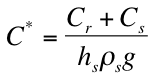

Relative wetness is the ratio of depth of water subsurface flow above an impervious layer to the depth of soil. 

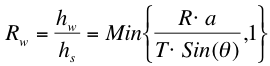

R: recharge rate to water table (m/d)
T: soil transmissivity (m^2/d)
a: specific catchment area (m).

** 1.2 Monte Carlo solution of the FS equation **

Below the Monte Carlo approach used by Strauch et al. (2018) is illustrated in a figure. At each node of the model grid variables for soil and vegetation are generated from triangular distributions. Recharge to water table is obtained from hydrologic model simulations by selecting the largest daily value for each year. Probability of shallow landslide initiation is defined as the ratio of number of times FS<1 to the total sample size of FS calculations.

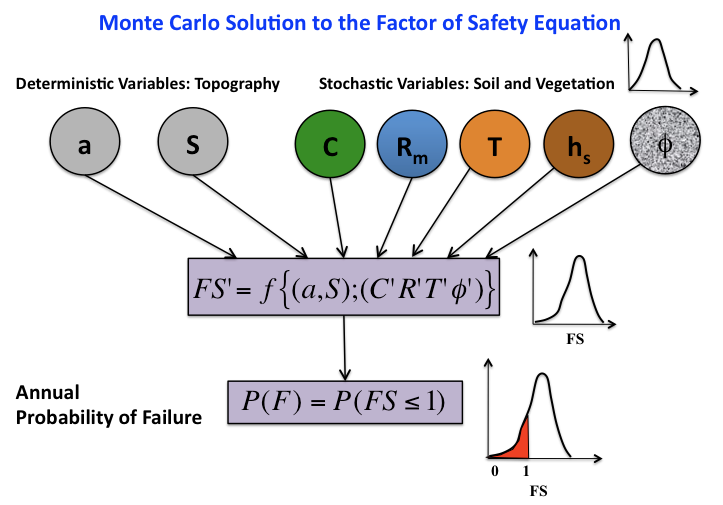

### Module overview for a Landlab Modeling Toolkit Landslide Introduction

This Jupyter Notebook runs the Landlab LandslideProbability component on a 30-m digital elevation model (DEM) for Thunder Creek, a subwaterhsed in the larger study domain developed by Strauch et al. (2018), using _data driven spatial_ recharge distribution as described in the paper (https://www.earth-surf-dynam.net/6/1/2018/).


To run a landslide demonstration using the paper data and approach we will:<br >
1) Import data from North Cascades National Park (NOCA: study area)<br />
2) Review data needed as input for the landslide model<br />
3) Create a RasterModelGrid based on a 30-m DEM - subset to Thunder Creek watershed<br />
4) Assign data fields used to calculate landslide probability<br />
5) Specify recharge option as _data driven spatial_ and access Python dictionaries to generate recharge distributions<br />
6) Set Number of iterations to run Monte Carlo simulation<br />
7) Run Landlab LandslideProbability component<br /> 
8) Run the model again to simulate post-fire conditions,<br />
9) Display and visualize results of stability analysis<br /> 
10) Save Notebook and Results back to HydroShare<br /> 
<br /> 

The estimated time to run this Notebook is 30-60 minutes with 20 minutes of computation time. 


## 2.0 Methods

## 2.1 Notebook Setup and Preparation

To run this notebook, we must import several libraries.
The hs_utils library provides functions for interacting with HydroShare, including resource querying, dowloading, and creation. Additional libraries support the functions of Landlab.

### 2.1.1 Install Python packages 
The CUAHSI JupyterHub server provides many Python packages and libraries, but to add additional libraries to your personal user space, use the cell below.  To request an Installation to the server, visit https://github.com/hydroshare/hydroshare-jupyterhub, create a New Issue, and add the label 'Installation Request'. Uncomment the lines below to install the library. Python2 and Python3 kernels are both available. If you are a new Landlab user on Hydroshare you are advised to run the code block below in your first run of this tutorial, then comment them out.

In [1]:
#!python2 -m pip install xarray
#!python2 -m pip install plotly
#!python2 -m pip install geopandas
#!python2 -m pip install rasterstats
#!python2 -m pip install affine
#!python2 -m pip install seaborn
#from __future__ import absolute_import, division, print_function, unicode_literals

### 2.2.2 Import Python libraries

In [2]:
#Import standard Python utilities for calculating and plotting
import six 
import os
import matplotlib as mpl
mpl.use('agg')
%matplotlib inline
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pickle as pickle
from datetime import datetime, timedelta
import geopandas as gpd

#Import utilities for importing and exporting to HydroShare
from utilities import hydroshare

# Import Landlab libraries
import landslide_probability
from landslide_probability import LandslideProbability
from landlab import imshow_grid_at_node
from landlab.io import read_esri_ascii
from landlab.io import write_esri_ascii
from collections import defaultdict
from landlab.plot import imshow_grid
from landlab import CORE_NODE, CLOSED_BOUNDARY

# Import general tools
import time
st = time.time()

### 2.1.3 Connection with HydroShare
After importing libraires, we now establish a secure connection with HydroShare by instantiating the hydroshare class that is defined within hs_utils. In addition to connecting with HydroShare, this command also sets and prints environment variables for several parameters that will be useful for saving work back to HydroShare.

In [3]:
hs=hydroshare.hydroshare()
homeresid=str(os.environ["HS_RES_ID"])
homedir = os.path.join('/home/jovyan/work/notebooks/data', str(homeresid),str(homeresid),'data/contents/')
print('This is a basic Unix folder structure.')
print('Data will be loaded from and saved to:'+homedir)

Adding the following system variables:
   HS_USR_NAME = ChristinaBandaragoda
   HS_RES_ID = 52b6a7e55f2e4b6ba2214d5e354d4af1
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => ChristinaBandaragoda

The hs_utils library requires a secure connection to your HydroShare account.
Enter the HydroShare password for user 'ChristinaBandaragoda': ········
Successfully established a connection with HydroShare
This is a basic Unix folder structure.
Data will be loaded from and saved to:/home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/


If you are curious about where the data is being downloaded, click on the Jupyter Notebook dashboard icon in upper rigth corner to see a File System view.  The homedir directory location printed above is where you can find the data and contents you will download to a HydroShare JupyterHub server.  At the end of this work session, you can migrate this data to the HydroShare iRods server as a Generic Resource. 

### 2.2. Import spatial data 
Strauch et al (2018) pre-processed the data for the North Cascades National Park Complex case study and is on HydroShare as [Regional landslide hazard using Landlab - NOCA Data](https://www.hydroshare.org/resource/a5b52c0e1493401a815f4e77b09d352b/). Here the first task is find this resource on Hydrohsare. We will click on the link to see the published data repository on HydroShare and collect the resource ID of the data. The resource ID can be found in the "How to cite" box, and it will be the series of numbers and letters following "hs.". Here's the copied resource: http://dx.doi.org/10.4211/hs.a5b52c0e1493401a815f4e77b09d352b citation. Now we copy this ID and introduce it as "Data_ResourceID=" in the code below. 

#### 2.2.1 Set DEM data download variable name
To learn more about this data visit [Regional landslide hazard using Landlab - NOCA Data](https://www.hydroshare.org/resource/a5b52c0e1493401a815f4e77b09d352b/)

In [4]:
Data_ResourceID='a5b52c0e1493401a815f4e77b09d352b'

#### 2.2.2 Download Data
We will execute the next cell to download data from HydroShare iRods database to your personal user space - this may take a few minutes.

In [5]:
hs.getResourceFromHydroShare(Data_ResourceID)
data_folder = os.path.join('/home/jovyan/work/notebooks/data', str(Data_ResourceID),str(Data_ResourceID),'data/contents/Data files/')
print('This is the location on the HydroShare JupyterHub server where the data has just been downloaded:')
print(data_folder)

This resource already exists in your userspace.
a5b52c0e1493401a815f4e77b09d352b/
|-- a5b52c0e1493401a815f4e77b09d352b/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- Data files/
|   |   |   |   |-- ASCII_header.txt
|   |   |   |   |-- cohesion_max.txt
|   |   |   |   |-- cohesion_min.txt
|   |   |   |   |-- cohesion_mode.txt
|   |   |   |   |-- cont_area.txt
|   |   |   |   |-- dict_coeff.p
|   |   |   |   |-- dict_uniq_ids.p
|   |   |   |   |-- elevation.txt
|   |   |   |   |-- exclud_mask.txt
|   |   |   |   |-- frict_angle.txt
|   |   |   |   |-- HSD_dict.p
|   |   |   |   |-- ksat_mpd.txt
|   |   |   |   |-- landslide_type.txt
|   |   |   |   |-- Re_annualMax_ex.txt
|   |   |   |   |-- sample_area.txt
|   |   |   |   |-- slope_tang17d.txt
|   |   |   |   |-- soil_depth_model.txt
|   |   |   |   |-- soil_depth.txt
|   |   |   | 

This is the location on the HydroShare JupyterHub server where the data has just been downloaded:
/home/jovyan/work/notebooks/data/a5b52c0e1493401a815f4e77b09d352b/a5b52c0e1493401a815f4e77b09d352b/data/contents/Data files/


 ### 2.3. Review data needed as input for the landslide model
 This section loads metadata associated with the Landlab component.  
 To view the code source for this component, visit [Landlab on Github](https://github.com/landlab/) or [Download the landslide_probability.py python file](https://github.com/landlab/landlab/blob/master/landlab/components/landslides/landslide_probability.py)


Check the list of data inputs that the component needs.

In [6]:
sorted(LandslideProbability.input_var_names)

['soil__density',
 'soil__internal_friction_angle',
 'soil__maximum_total_cohesion',
 'soil__minimum_total_cohesion',
 'soil__mode_total_cohesion',
 'soil__saturated_hydraulic_conductivity',
 'soil__thickness',
 'soil__transmissivity',
 'topographic__slope',
 'topographic__specific_contributing_area']

Review the details of what each variable represents.

In [7]:
LandslideProbability._var_doc

{'topographic__specific_contributing_area': 'specific contributing (upslope area/cell face ) that drains to node',
 'topographic__slope': 'slope of surface at node represented by tan theta',
 'soil__transmissivity': 'mode rate of water transmitted through a unit width of saturated soil - either provided or calculated with Ksat and soil depth',
 'soil__saturated_hydraulic_conductivity': 'mode rate of water transmitted through soil - provided if transmissivity is NOT provided to calculate tranmissivity  with soil depth',
 'soil__mode_total_cohesion': 'mode of combined root and soil cohesion at node',
 'soil__minimum_total_cohesion': 'minimum of combined root and soil cohesion at node',
 'soil__maximum_total_cohesion': 'maximum of combined root and soil cohesion at node',
 'soil__internal_friction_angle': 'critical angle just before failure due to friction between particles',
 'soil__density': 'wet bulk density of soil',
 'soil__thickness': 'soil depth to restrictive layer',
 'soil__mean_

Check the units of each variable.

In [8]:
LandslideProbability._var_units

{'topographic__specific_contributing_area': 'm',
 'topographic__slope': 'tan theta',
 'soil__transmissivity': 'm2/day',
 'soil__saturated_hydraulic_conductivity': 'm/day',
 'soil__mode_total_cohesion': 'Pa or kg/m-s2',
 'soil__minimum_total_cohesion': 'Pa or kg/m-s2',
 'soil__maximum_total_cohesion': 'Pa or kg/m-s2',
 'soil__internal_friction_angle': 'degrees',
 'soil__density': 'kg/m3',
 'soil__thickness': 'm',
 'soil__mean_relative_wetness': 'None',
 'landslide__probability_of_failure': 'None',
 'soil__probability_of_saturation': 'None'}

Now we will establish a RasterModelGrid based on a DEM for assigning our variables to.
Nodes are the center point of grid cells or pixels that are 30 m by 30 m in this example. 

### 2.4. Create a watershed subset using a regional RasterModelGrid

The shapefile that you will download is a GIS point file with a table containing a grid_code for each 30m DEM cell in the Thunder Creek watershed. We import this table to generate a list of locations we want to keep "Open" as active nodes in this Landlab application for Thunder Creek.   

Here we will establish the watershed domain for our modeling study. In step 2.2.2, we have downloaded the DEM of the entire NOCA study region of Strauch et al. (2018) as well as other input data. This includes NoData resource that was created using a mask of Thunder Creek will be downladed and used to set no data nodes as inactive nodes (e.g., -9999). This step will establish boundary conditions. In your final run when you output modeled probability of landslide initiation, you will notice gaps in the model results at some ridge tops and peaks. This results from excluding glaciated areas and bedrock. <br />
This might take a few minutes as the park is large (2,757 km2).

This shapefile resource was uploaded to HydroShare to generate an interoperable Notebook.  To learn more about this data visit [Thunder Creek Landlab Node ID Point Shapefile
](https://www.hydroshare.org/resource/8bf8de77227c4dcba4816dbe15e55687/)

#### 2.4.1 Get shapefile of ThunderCreek watershed
The shapefile table contains Landlab Gridcode value and Albers Conical X and Y values, spatial projection is WGS84.  

In [9]:
Data_ResourceID='8bf8de77227c4dcba4816dbe15e55687'
hs.getResourceFromHydroShare(Data_ResourceID)

This resource already exists in your userspace.
8bf8de77227c4dcba4816dbe15e55687/
|-- 8bf8de77227c4dcba4816dbe15e55687/
|   |-- bagit.txt
|   |-- manifest-md5.txt
|   |-- readme.txt
|   |-- tagmanifest-md5.txt
|   |-- data/
|   |   |-- resourcemap.xml
|   |   |-- resourcemetadata.xml
|   |   |-- contents/
|   |   |   |-- Thunder_node_id_WGS.cpg
|   |   |   |-- Thunder_node_id_WGS.dbf
|   |   |   |-- Thunder_node_id_WGS.prj
|   |   |   |-- Thunder_node_id_WGS.sbn
|   |   |   |-- Thunder_node_id_WGS.sbx
|   |   |   |-- Thunder_node_id_WGS.shp
|   |   |   |-- Thunder_node_id_WGS.shx

Do you want to overwrite these data [Y/n]? n


In [10]:
Node_path = os.path.join('/home/jovyan/work/notebooks/data',str(Data_ResourceID),str(Data_ResourceID),'data/contents/','Thunder_node_id_WGS.shp')
print(Node_path)
NodeID_shpfile=gpd.GeoDataFrame.from_file(Node_path)

/home/jovyan/work/notebooks/data/8bf8de77227c4dcba4816dbe15e55687/8bf8de77227c4dcba4816dbe15e55687/data/contents/Thunder_node_id_WGS.shp


Print a sample portion (bottom) of the table
* Col 1 = FID or POINTID
* Col 2 = landlab grid code for NOCA region
* Col 3 Point_X - the Alber Conical Latitude (original dataset)
* Col 4 Point_Y -  the Alber Conical Longitude (original dataset)
* Geometry of lat/lon in WGS coordinate system of this GIS point file for launching in HydroShareGIS App

In [11]:
NodeID_shpfile.tail()

,POINTID,GRID_CODE,POINT_X,POINT_Y,geometry
306808,0,2348058,-1841730.0,3076320.0,POINT (-120.9517781910061 48.49903226527576)
306809,0,2348059,-1841700.0,3076320.0,POINT (-120.9513901735801 48.49910301141747)
306810,0,2348060,-1841670.0,3076320.0,POINT (-120.9510021553025 48.49917375650436)
306811,0,2348061,-1841640.0,3076320.0,POINT (-120.9506141361734 48.49924450053641)
306812,0,2345876,-1841640.0,3076290.0,POINT (-120.9505098563902 48.49898126887325)


Make an array using Grid_Code column to develop a node based mask. No output from this command.

In [12]:
filtercriteria = np.array(NodeID_shpfile.GRID_CODE)

#### Load  spatial landslide model inputs from ASCII textfile (ArcGIS raster conversion) into Landlab grid

Create Landlab RasterModelGrid using DEM grid with elevation - this takes approximately 60 sec for the North Cascades National Park (NOCA). 

In [13]:
(grid, z) = read_esri_ascii(data_folder+'/elevation.txt',name='topographic__elevation')
grid.at_node.keys()

dict_keys(['topographic__elevation'])

The original NOCA dem dataset has nodes closed outside of NOCA.
All nodes insides of NOCA are open. To close all all nodes except those inside Thunder Creek: 
* Close all nodes in the landlab RasterModelGrid.
* Open the Landlab RasterModelGrid only within the Thunder Creek watershed.
* Assign Core Nodes (these are the only nodes where computation will be executed).

Plot the elevation grid of NOCA

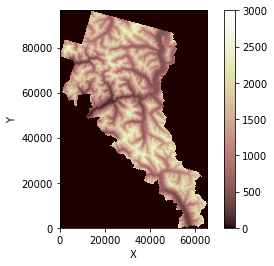

In [14]:
imshow_grid(grid, 'topographic__elevation', limits=(0, 3000))

Plot where the watershed is witin NOCA and zoom in.

In [15]:
grid.status_at_node[grid.nodes.flatten()] = CLOSED_BOUNDARY
grid.status_at_node[filtercriteria] = CORE_NODE

In [16]:
# In case the DEM has no data values inside the subset area, set boundary conditions closed.
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__elevation'], -9999) 

(30000, 55000)

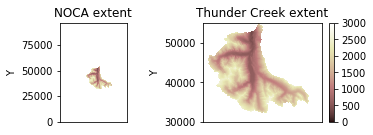

In [17]:
fig = plt.figure('Limit NOCA computational nodes to Thunder Creek extent')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(False)
imshow_grid(grid, 'topographic__elevation', limits=(0, 3000),plot_name='NOCA extent',
                    allow_colorbar=False,color_for_closed='white')
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(False)
imshow_grid(grid, 'topographic__elevation', limits=(0, 3000),plot_name='Thunder Creek extent',color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)

Confirm the size of the grid, nodes located every 30 m.

In [18]:
grid.number_of_nodes

7029145

Confirm the size of the core nodes where we'll run our model, a subset of the nodes for the watershed.

In [19]:
grid.number_of_core_nodes

306798

### 2.5. Attach data (e.g., soil and vegetation variables) to the Landlab rastermodelgrid
This will be used to calculate shallow landslide probability and set boundary conditions. THe data we attach in this step was downloaded in Step 2.2.2. 

#### For each input below
1. Load data from ascii text file
2. Add this data as node variable to the Thunder Creek grid
3. Set boundary conditions

For the entire NOCA extent, this takes ~60 sec to load each file using the CUAHSI JupyterHub server. 

#### 2.5.1 Load slope


In [20]:
(grid1, slope) = read_esri_ascii(data_folder+'/slope_tang17d.txt')
grid.add_field('node', 'topographic__slope', slope)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__slope'], -9999)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__slope'], 0.0)

In [21]:
print(np.max(grid.at_node['topographic__slope'][grid.core_nodes]))
print(np.min(grid.at_node['topographic__slope'][grid.core_nodes]))

4.430756
0.3057313


#### 2.5.2 Load contributing area

In [22]:
(grid1, ca) = read_esri_ascii(data_folder+'/cont_area.txt')
grid.add_field('node', 'topographic__specific_contributing_area', ca)
grid.set_nodata_nodes_to_closed(grid.at_node['topographic__specific_contributing_area'], -9999)

#### 2.5.3 Load transmissivity

In [23]:
(grid1, T) = read_esri_ascii(data_folder+'/transmis.txt')
grid.add_field('node', 'soil__transmissivity', T)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__transmissivity'], -9999)

#### 2.5.4 Load cohesion (mode, min, and max) 
This takes ~3 minutes because 3 cohesion fields are provided to create more flexibility in how cohesion is distributed on the landscape with different vegetation.

In [24]:
(grid1, C) = read_esri_ascii(data_folder+'/cohesion_mode.txt')
C[C == 0.0] = 1.0  # ensure minimum is >0 Pa for use in distributions generation
grid.add_field('node', 'soil__mode_total_cohesion', C)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__mode_total_cohesion'], -9999)

(grid1, C_min) = read_esri_ascii(data_folder+'/cohesion_min.txt')
grid.add_field('node', 'soil__minimum_total_cohesion', C_min)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__minimum_total_cohesion'], -9999)

(grid1, C_max) = read_esri_ascii(data_folder+'/cohesion_max.txt')
grid.add_field('node', 'soil__maximum_total_cohesion', C_max)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__maximum_total_cohesion'], -9999)

#### 2.5.5 Load internal angle of friction

In [25]:
(grid1, phi) = read_esri_ascii(data_folder+'/frict_angle.txt')
grid.add_field('node', 'soil__internal_friction_angle', phi)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__internal_friction_angle'], -9999)

#### 2.5.6 Set soil density values
In this example, we assign all nodes a constant value.

In [26]:
grid['node']['soil__density'] = 2000*np.ones(grid.number_of_nodes)

#### 2.5.7 Load soil thickness

In [27]:
(grid1, hs) = read_esri_ascii(data_folder+'/soil_depth.txt')
grid.add_field('node', 'soil__thickness', hs)
grid.set_nodata_nodes_to_closed(grid.at_node['soil__thickness'], -9999)

#### 2.5.8 Load observed landslide inventory. Class 1-5 are landslides, 8 is no landslide mapped for later plotting

In [28]:
(grid1, slides) = read_esri_ascii(data_folder+'/landslide_type.txt')
grid.add_field('node', 'landslides', slides)

array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

### 2.6. Specify recharge option as _data driven spatial_ and access Python dictionaries to generate recharge distributions 
Recharge in this model represents the annual maximum recharge in mm/day generated within the upslope contributing area of each model element. This corresponds to the wettest conditions expected annually, which would provide the highest pore-water pressure in a year. Details of this approach can be found in Strauch et al. (2018).

#### 2.6.1 Select recharge method from the component

In [29]:
distribution = 'data_driven_spatial'

#### 2.6.2 Load pre-processed routed flows dictionaries 
These contain HSD_id and fractional drainage at each node and recharge dictionaries.  HSD is the Hydrologic Source Domain, which is the VIC hydrologic model data in this case study at ~5x6 km2 grid size.  The 'pickle' utility loads existing dictionaries.

In [30]:
# dict of node id (key) and HSD_ids (values)
HSD_id_dict = pickle.load(open(data_folder+'/dict_uniq_ids.p', 'rb'),encoding='latin1')
# dict of node id (key) and fractions (values)
fract_dict = pickle.load(open(data_folder+'/dict_coeff.p', 'rb'),encoding='latin1')
# dict of HSD id (key) with arrays of recharge (values)
HSD_dict = pickle.load(open(data_folder+'/HSD_dict.p', 'rb'),encoding='latin1')

#### 2.6.3 Combine dictionaries into __ordered__ parameters
This sequence of parameters is required for _data driven spatial_ distribution in the component.  Recharge is this model is unique to each node represented by an array. 

In [31]:
HSD_inputs = [HSD_dict, HSD_id_dict, fract_dict]

### 2.7. Set Number of iterations to run Monte Carlo simulation

The landslide component employes the infinite slope model to calculate factor-of-safety index values using a Monte Carlo simulation, which randomly selects input values from parameter distributions. You can specify the number of Monte Carlo samples, but the default is 250. The larger the Monte Carlos sample size, the longer the program runs, but the more precise the probability of failure results become. Strauch et al. (2018) sampled 3,000 times for each parameter in each model grid.

In [32]:
iterations = 250

## 3. Results

### 3.1. Run the Landlab LandslideProbability Component in Thunder Creek for pre-fire conditions

#### 3.1.1 Initialize Pre-fire
To run the landslide model, we first instantiate the LandslideProbability component with the above parameters, as well as the grid and number of samples we specified before. Instantiation creates an instance of a class called LS_prob. 

No outputs are generated by this command as it is setting up the recharge and instantiating the component.

In [33]:
LS_prob = LandslideProbability(grid,
    number_of_iterations=iterations,
    groudwater__recharge_distribution=distribution,
    groudwater__recharge_HSD_inputs=HSD_inputs)

#### 3.1.2 Run the Pre-fire model
Once the component has been instantiated, we generate outputs from running the component by calling the component's 'calculate_landslide_probability' method using the class instance (e.g., LS_prob). The cell below runs the model; in the following section we will assessing the results. These calculations will take a few minutes given the size of the modeling domain represented by core nodes.

In [34]:
LS_prob.calculate_landslide_probability()
print('Landslide probability successfully calculated')

Landslide probability successfully calculated


What is the maximum probabilty of failure we found?

In [35]:
np.max(grid.at_node['landslide__probability_of_failure'][grid.core_nodes])

1.0

The outputs of landslide model simulation are:

In [36]:
sorted(LS_prob.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__probability_of_saturation']

This simulation generates a probability value for each core node. 

In [37]:
grid.at_node['landslide__probability_of_failure']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

This simulation generates a probability of saturation value for each core node as well.

In [38]:
grid.at_node['soil__probability_of_saturation']

array([-9999., -9999., -9999., ..., -9999., -9999., -9999.])

-9999 means there is no data for that cell, it is a closed node.

### 3.2. Run the Landlab LandslideProbability Component in Thunder Creek for fire conditions

Make a 'grid_fire' version of 'grid' for which we will give post-fire cohesion parameter values 30% of the original cohesion. This is a crude estimation of the lowest root cohesion after tree removal based on a combined decay and regrowth model (e.g., Sidle, 1992).

Sidle, R. C. (1992), A theoretical model of the effects of timber harvesting
on slope stability, Water Resour. Res., 28(7), 1897–1910.

#### 3.2.1 Make a Post-fire copy of the grid

In [39]:
import copy
grid_fire=copy.deepcopy(grid)
grid_fire.at_node['soil__mode_total_cohesion']=grid.at_node['soil__mode_total_cohesion']*0.3
grid_fire.at_node['soil__minimum_total_cohesion']=grid.at_node['soil__minimum_total_cohesion']*0.3
grid_fire.at_node['soil__maximum_total_cohesion']=grid.at_node['soil__maximum_total_cohesion']*0.3

#### 3.2.2 Change the Post-fire cohesion values 

In [40]:
print("this is the highest mode value for coehsion before fire across the domain")
print(np.max(grid.at_node['soil__mode_total_cohesion'][grid.core_nodes]))
print("this is the lowest mode value for coehsion before fire across the domain")
print(np.min(grid.at_node['soil__mode_total_cohesion'][grid.core_nodes]))
print("this is the highest mode value for coehsion after fire across the domain")
print(np.max(grid_fire.at_node['soil__mode_total_cohesion'][grid.core_nodes]))
print("this is the lowest mode value for coehsion after fire across the domain")
print(np.min(grid_fire.at_node['soil__mode_total_cohesion'][grid.core_nodes]))

this is the highest mode value for coehsion before fire across the domain
10000.0
this is the lowest mode value for coehsion before fire across the domain
100.0
this is the highest mode value for coehsion after fire across the domain
3000.0
this is the lowest mode value for coehsion after fire across the domain
30.0


#### 3.2.3  Initialize the Post-fire model
Now we'll run the landslide component with the adjusted cohesion, everything else kept constant.

In [41]:
LS_probFire = LandslideProbability(grid_fire,number_of_iterations=iterations,
    groudwater__recharge_distribution=distribution,
    groudwater__recharge_HSD_inputs=HSD_inputs)
print('Post-fire cohesion successfully instantiated')

Post-fire cohesion successfully instantiated


#### 3.2.4 Run the Post-fire model

In [42]:
LS_probFire.calculate_landslide_probability()
print('Landslide probability successfully calculated')

Landslide probability successfully calculated


In [43]:
np.max(grid_fire.at_node['landslide__probability_of_failure'][grid.core_nodes])

1.0

The outputs of landslide model simulation are:

In [44]:
sorted(LS_probFire.output_var_names)

['landslide__probability_of_failure',
 'soil__mean_relative_wetness',
 'soil__probability_of_saturation']


This simulation generates a probability value for each core node. 

In [45]:
grid_fire.at_node['landslide__probability_of_failure']

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

### 3.3. Display and visualize results of stability analysis

Set plotting parameters

In [46]:
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 15

Plot elevation

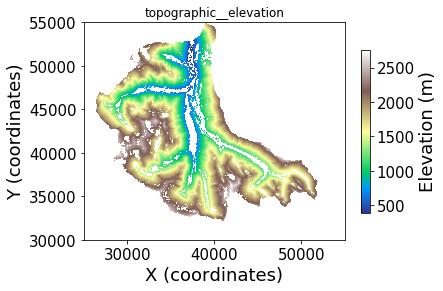

In [47]:
plt.figure('Elevations from the DEM [m]')
imshow_grid_at_node(grid, 'topographic__elevation', cmap='terrain',
                 grid_units=('coordinates', 'coordinates'),
                 shrink=0.75, var_name='Elevation', var_units='m',color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)
plt.savefig('NOCA_elevation.png')

Excluded areas from the analysis are shown in black, including outside the park and inside the park areas that are water bodies, snow, glaciers, wetlands, exposed bedrock, and slopes <= 17 degrees. 

Plot slope overlaid with mapped landslide types. Takes about a few minutes.

(30000, 55000)

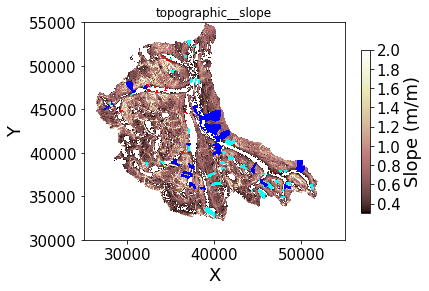

In [48]:
plt.figure('Landslides')
ls_mask1 = grid.at_node['landslides'] != 1.0
ls_mask2 = grid.at_node['landslides'] != 2.0
ls_mask3 = grid.at_node['landslides'] != 3.0
ls_mask4 = grid.at_node['landslides'] != 4.0
overlay_landslide1 = np.ma.array(grid.at_node['landslides'], mask=ls_mask1)
overlay_landslide2 = np.ma.array(grid.at_node['landslides'], mask=ls_mask2)
overlay_landslide3 = np.ma.array(grid.at_node['landslides'], mask=ls_mask3)
overlay_landslide4 = np.ma.array(grid.at_node['landslides'], mask=ls_mask4)
imshow_grid_at_node(grid, 'topographic__slope', cmap='pink',
                 grid_units=('coordinates', 'coordinates'), vmax=2.,
                 shrink=0.75, var_name='Slope', var_units='m/m',color_for_closed='white',)
imshow_grid_at_node(grid, overlay_landslide1, color_for_closed='None',
                 allow_colorbar=False, cmap='cool')
imshow_grid_at_node(grid, overlay_landslide2, color_for_closed='None',
                 allow_colorbar=False, cmap='autumn')
imshow_grid_at_node(grid, overlay_landslide3, color_for_closed='None',
                 allow_colorbar=False, cmap='winter')
imshow_grid_at_node(grid, overlay_landslide4, color_for_closed='None',
                 allow_colorbar=False,cmap='summer')
#plt.savefig('NOCA_Landslides_on_Slope.png')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)

Legend to mapped landslides: blue - debris avalanches, cyan - falls/topples, red - debris torrents, and green - slumps/creeps

Plot of soil depth (m)

(30000, 55000)

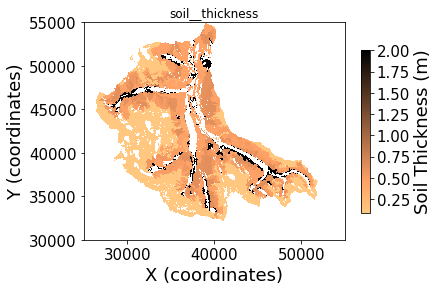

In [49]:
plt.figure('Soil Thickness')
imshow_grid_at_node(grid, 'soil__thickness', cmap='copper_r',
                 grid_units=('coordinates', 'coordinates'), shrink=0.75,
                 var_name='Soil Thickness', var_units='m', color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)
#plt.savefig('NOCA_SoilDepth.png')

Plot probability of saturation 

(30000, 55000)

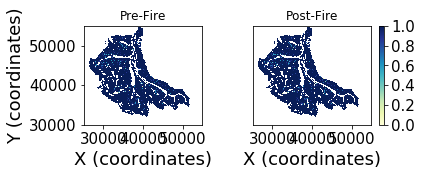

In [50]:
fig = plt.figure('Probability of Saturation')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
ax1.xaxis.set_visible(True)
imshow_grid(grid, 'soil__probability_of_saturation',cmap='YlGnBu',
                 limits=((0), (1)),plot_name='Pre-Fire',
                 allow_colorbar=False,grid_units=('coordinates', 'coordinates'), color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)
ax2 = fig.add_subplot(222)
ax2.xaxis.set_visible(True)
ax2.yaxis.set_visible(False)
imshow_grid(grid_fire, 'soil__probability_of_saturation',cmap='YlGnBu',
                 limits=((0), (1)),plot_name='Post-Fire',grid_units=('coordinates', 'coordinates'), color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)

This map shows the probability of saturation as high throughout much of the area because we modeled the annual maximum recharge, which is esssentially the worst case conditions that might lead to instability.

Plot probability of failure; Compare this with the elevation and slope maps.

(30000, 55000)

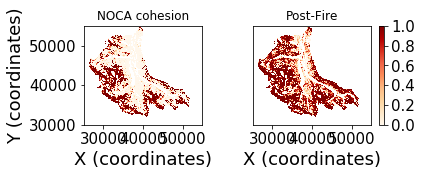

In [51]:
fig = plt.figure('Probability of Failure')
xticks = np.arange(-0.1, 0.8, 0.4)
ax1 = fig.add_subplot(221)
#ax1.xaxis.set_visible(False)
imshow_grid(grid, 'landslide__probability_of_failure',cmap='OrRd',
                 limits=((0), (1)),plot_name='NOCA cohesion',
                 allow_colorbar=False,grid_units=('coordinates', 'coordinates'), color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)
ax2 = fig.add_subplot(222)
ax2.yaxis.set_visible(False)
imshow_grid(grid_fire, 'landslide__probability_of_failure',cmap='OrRd',
                 limits=((0), (1)),plot_name='Post-Fire',grid_units=('coordinates', 'coordinates'), color_for_closed='white')
plt.xlim(25000, 55000)
plt.ylim(30000, 55000)

#plt.savefig('Probability_of_Failure_Original_Fire.png')

The map of probability of failure shows higher probabilities in a post-fire scenario with reduced cohesion.

To review the fields assigned to the grid, simply execute the following command.

In [52]:
grid.at_node

{'topographic__elevation': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'topographic__slope': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'topographic__specific_contributing_area': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__transmissivity': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__mode_total_cohesion': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__minimum_total_cohesion': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__maximum_total_cohesion': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__internal_friction_angle': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__density': array([ 2000.,  2000.,  2000., ...,  2000.,  2000.,  2000.]),
 'soil__thickness': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'landslides': array([-9999., -9999., -9999., ..., -9999., -9999., -9999.]),
 'soil__saturate

(array([  6.79016800e+06,   3.29900000e+03,   2.60800000e+03,
          2.33300000e+03,   1.93800000e+03,   1.77300000e+03,
          1.69800000e+03,   2.37800000e+03,   1.38600000e+03,
          1.41600000e+03,   1.31400000e+03,   1.30900000e+03,
          1.32000000e+03,   1.82400000e+03,   1.26200000e+03,
          1.20000000e+03,   1.16800000e+03,   1.19200000e+03,
          1.11900000e+03,   1.12600000e+03,   1.62200000e+03,
          1.06200000e+03,   1.05300000e+03,   1.10000000e+03,
          1.02800000e+03,   1.58700000e+03,   1.01400000e+03,
          9.38000000e+02,   9.35000000e+02,   9.15000000e+02,
          1.43500000e+03,   9.02000000e+02,   9.12000000e+02,
          8.85000000e+02,   1.38100000e+03,   8.65000000e+02,
          8.50000000e+02,   8.80000000e+02,   1.23700000e+03,
          8.57000000e+02,   7.88000000e+02,   7.92000000e+02,
          1.32500000e+03,   8.41000000e+02,   8.60000000e+02,
          1.22700000e+03,   8.02000000e+02,   8.32000000e+02,
        

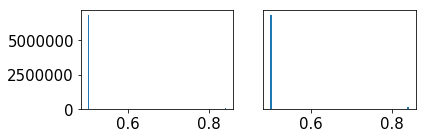

In [64]:
import scipy.stats as ss

fig = plt.figure('Histograms of Probability of Failure')
ax1 = fig.add_subplot(221)
#ax1.xaxis.set_visible(False)
plt.hist(ss.norm.cdf(grid.at_node['landslide__probability_of_failure']),bins=100)

ax2 = fig.add_subplot(222)
ax2.yaxis.set_visible(False)
plt.hist(ss.norm.cdf(grid_fire.at_node['landslide__probability_of_failure']),bins=100)


Export data from model run: FS probability, mean Reletive wetness, probability of saturation

In [65]:
import pandas as pd
core_nodes = grid.core_nodes
data_extracted = {'Prob_fail_std': np.array(
                 grid.at_node['landslide__probability_of_failure'][grid.core_nodes]),
                 'mean_RW_std': np.array(grid.at_node['soil__mean_relative_wetness']
                 [grid.core_nodes]),'prob_sat_std': np.array(
                 grid.at_node['soil__probability_of_saturation'][grid.core_nodes]),
                 'Prob_fail_fire': np.array(
                 grid_fire.at_node['landslide__probability_of_failure'][grid_fire.core_nodes]),
                 'mean_RW_fire': np.array(grid_fire.at_node['soil__mean_relative_wetness']
                 [grid_fire.core_nodes]),'prob_sat_fire': np.array(
                 grid_fire.at_node['soil__probability_of_saturation'][grid_fire.core_nodes])}
headers = ['Prob_fail_std','mean_RW_std','prob_sat_std','Prob_fail_fire','mean_RW_fire','prob_sat_fire']
df = pd.DataFrame(data_extracted, index=core_nodes, columns=(headers))
df.to_csv('Landslide_std_fire.csv')

Make ascii files for raster creation in GIS

In [ ]:
write_esri_ascii('prob_fail_std.txt',grid,names='landslide__probability_of_failure')
write_esri_ascii('mean_RW_std.txt',grid,names='soil__mean_relative_wetness')
write_esri_ascii('prob_sat_std.txt',grid,names='soil__probability_of_saturation')
write_esri_ascii('prob_fail_fire.txt',grid_fire,names='landslide__probability_of_failure')
write_esri_ascii('mean_RW_fire.txt',grid_fire,names='soil__mean_relative_wetness')
write_esri_ascii('prob_sat_fire.txt',grid_fire,names='soil__probability_of_saturation')

How long did the code above take to run?

In [55]:
print('Elapsed time is %3.2f seconds' % (time.time() - st))

Elapsed time is 1527.86 seconds


## 4.0. Save the results back into HydroShare
<a name="creation"></a>

Using the `hs_utils` library, the results of the Geoprocessing steps above can be saved back into HydroShare.  First, define all of the required metadata for resource creation, i.e. *title*, *abstract*, *keywords*, *content files*.  In addition, we must define the type of resource that will be created, in this case *genericresource*.  

***Note:*** Make sure you save the notebook at this point, so that all notebook changes will be saved into the new HydroShare resource.


***Option A*** : define the resource from which this "NEW" content has been derived.  This is one method for tracking resource provenance.

Create list of files to save to HydroShare. Verify location and names.

In [67]:
ThisNotebook='replicate_landslide_model_for_fire.ipynb' #check name for consistency
files=[homedir+ ThisNotebook,
       homedir+'Landslide_std_fire.csv',
       homedir+ 'prob_fail_std.txt',
       homedir+ 'mean_RW_std.txt',
       homedir+ 'prob_sat_std.txt',
       homedir+ 'prob_fail_fire.txt',
       homedir+ 'mean_RW_fire.txt',
       homedir+ 'prob_sat_fire.txt']
print(files) #print location and names of files to save

['/home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/replicate_landslide_model_for_fire.ipynb', '/home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/Landslide_std_fire.csv', '/home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/prob_fail_std.txt', '/home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/mean_RW_std.txt', '/home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/prob_sat_std.txt', '/home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/prob_fail_fire.txt', '/home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/mean_RW_fire.txt', '/home/jovyan/work/notebooks/data/52

In [68]:
hs=hydroshare.hydroshare()
help(hs)

Adding the following system variables:
   HS_USR_NAME = ChristinaBandaragoda
   HS_RES_ID = 52b6a7e55f2e4b6ba2214d5e354d4af1
   HS_RES_TYPE = compositeresource
   JUPYTER_HUB_IP = jupyter.cuahsi.org

These can be accessed using the following command: 
   os.environ[key]

   (e.g.)
   os.environ["HS_USR_NAME"]  => ChristinaBandaragoda
Successfully established a connection with HydroShare
Help on hydroshare in module utilities.hydroshare.hydroshare object:

class hydroshare(builtins.object)
 |  Methods defined here:
 |  
 |  __init__(self, username=None, password=None, cache=True)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  addContentToExistingResource(self, resid, content)
 |      Adds content files to an existing hydroshare resource.
 |      
 |      args:
 |      -- resid: id of an existing hydroshare resource (str)
 |      -- content: files paths to be added to resource (list)
 |      
 |      returns:
 |      -- None
 |  
 |  createHydroShareResou

In [69]:
# for each file downloaded onto the server folder, move to a new HydroShare Generic Resource
title = 'Landslide Model run with Monte Carlo from NOCA Observatory - Thunder Creek with Fire' # title for the new resource
abstract = 'This a reproducible demonstration of the landslide modeling results from eSurf paper: Strauch et al. (2018) ' # abstract for the new resource
keywords = ['landslide', 'climate', 'VIC','saturation','relative wetness','fire','Geohackweek'] # keywords for the new resource
rtype = 'genericresource'          # Hydroshare resource type

# create the new resource
resource_id = hs.createHydroShareResource(abstract, 
                                          title,
                                          keywords=keywords, 
                                          resource_type=rtype, 
                                          content_files=files, 
                                          public=False)

Resource Created Successfully                           


Exception in thread Thread-7:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/work/notebooks/utilities/hydroshare/threads.py", line 23, in f
    res = self.func(*args, **kwargs)
  File "/opt/conda/lib/python3.6/site-packages/hs_restclient/__init__.py", line 738, in createResource
    close_fd = self._prepareFileForUpload(params, resource_file, resource_filename)
  File "/opt/conda/lib/python3.6/site-packages/hs_restclient/__init__.py", line 170, in _prepareFileForUpload
    raise HydroShareArgumentException("{0} is not a file or is not readable.".format(resource_file))
hs_restclient.exceptions.HydroShareArgumentException: /home/jovyan/work/notebooks/data/52b6a7e55f2e4b6ba2214d5e354d4af1/52b6a7e55f2e4b6ba2214d5e354d4af1/data/contents/replicate_landslide_model_for_fire.ipynb is n

Successfully Added Content Files                      
